## Saved and load the trained model

This notebook showcases how to save and load a trained model.

In [2]:
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)
import jax
import optax
from jax import random
import jax.numpy as jnp

from priorCVAE.models import MLPEncoder, MLPDecoder, VAE
from priorCVAE.priors import SquaredExponential
from priorCVAE.datasets import GPDataset
from priorCVAE.trainer import VAETrainer
from priorCVAE.losses import SquaredSumAndKL
from priorCVAE.utility import save_model_params, load_model_params, create_grid

import jax.config as config
config.update("jax_enable_x64", True)

In [3]:
# Configuration dictionary
args = {
        "input_dim" : 40,
        "hidden_dim": 40,
        "latent_dim": 30,
        "batch_size": 500,
        "num_iterations": 2000,
        "model_path": f"output/{rnd.randint(0, 200)}"
       }

### Generate data and train a model

We generate data using a SquaredExponential Kernel with a fixed lengthscale of $0.4$ and train a priorCVAE model. 

In [4]:
kernel = SquaredExponential(lengthscale=.4)
x = create_grid(n_data=args["input_dim"])

gp_set = GPDataset(kernel=kernel, x=x, sample_lengthscale=False)  

sample_x_train, sample_y_train, sample_ls_train = gp_set.simulatedata(n_samples=1000)
x_test, y_test, ls_test = gp_set.simulatedata(n_samples=50)

In [5]:
encoder = MLPEncoder(args["hidden_dim"], args["latent_dim"])
decoder = MLPDecoder(args["hidden_dim"], args["input_dim"])
model = VAE(encoder, decoder)

optimizer = optax.adam(learning_rate=0.001)
loss = SquaredSumAndKL(conditional=True)

trainer = VAETrainer(model, optimizer, loss=loss)
trainer.init_params(sample_y_train[0], c=sample_ls_train[0])

test_set = (x_test, y_test, ls_test)
loss_vals, test_vals, time_taken = trainer.train(gp_set, test_set, args["num_iterations"])

print(f'Training of {args["num_iterations"]} epochs took {round(time_taken)} seconds')

[    1] training loss: 3017.022, test loss: 1566.561
[   11] training loss: 2419.376, test loss: 1248.003
[   21] training loss: 2232.407, test loss: 1082.412
[   31] training loss: 2080.319, test loss: 1013.731
[   41] training loss: 2322.329, test loss: 993.516
[   51] training loss: 1770.569, test loss: 938.138
[   61] training loss: 2227.235, test loss: 887.303
[   71] training loss: 1641.945, test loss: 842.041
[   81] training loss: 1450.030, test loss: 823.965
[   91] training loss: 1903.404, test loss: 735.771
[  101] training loss: 1311.106, test loss: 683.173
[  111] training loss: 1202.626, test loss: 645.139
[  121] training loss: 1162.628, test loss: 597.217
[  131] training loss: 1199.568, test loss: 596.166
[  141] training loss: 1238.804, test loss: 576.088
[  151] training loss: 1141.959, test loss: 536.905
[  161] training loss: 1162.511, test loss: 586.716
[  171] training loss: 952.264, test loss: 580.377
[  181] training loss: 1054.302, test loss: 534.723
[  191] t

[ 1611] training loss: 513.750, test loss: 269.965
[ 1621] training loss: 513.099, test loss: 278.668
[ 1631] training loss: 540.060, test loss: 273.504
[ 1641] training loss: 537.875, test loss: 263.550
[ 1651] training loss: 515.289, test loss: 260.309
[ 1661] training loss: 490.655, test loss: 280.260
[ 1671] training loss: 485.394, test loss: 289.232
[ 1681] training loss: 486.627, test loss: 286.652
[ 1691] training loss: 496.445, test loss: 251.539
[ 1701] training loss: 514.209, test loss: 269.931
[ 1711] training loss: 486.079, test loss: 278.316
[ 1721] training loss: 505.286, test loss: 265.193
[ 1731] training loss: 497.373, test loss: 262.853
[ 1741] training loss: 515.768, test loss: 272.158
[ 1751] training loss: 518.831, test loss: 256.040
[ 1761] training loss: 526.697, test loss: 265.870
[ 1771] training loss: 505.159, test loss: 279.195
[ 1781] training loss: 551.802, test loss: 278.168
[ 1791] training loss: 512.731, test loss: 270.353
[ 1801] training loss: 516.129,

## Save the model

Save the parameters of a trained model.

In [6]:
save_model_params(args["model_path"], trainer.state.params)

## Create a new decoder

We create a new decoder, initialize the parameters randomly and plot a few sampples. 

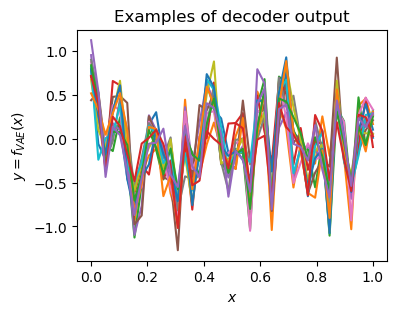

In [7]:
new_decoder = MLPDecoder(args["hidden_dim"], args["input_dim"])

key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (args["batch_size"], args["latent_dim"]))
c = .4 * jnp.ones((z.shape[0], 1))
z_c = jnp.concatenate([z, c], axis=-1)

key = jax.random.PRNGKey(rnd.randint(0, 9999))
key, rng = jax.random.split(key, 2)
params = new_decoder.init(rng, z_c)['params']

out = new_decoder.apply({'params': params}, z_c)             

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(sample_x_train[0], out[i,:])
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of decoder output')

plt.show()

## Load the model

Now, we load the trained parameters from the saved model file and plots the samples from the decoder again.

In [8]:
trained_decoder_params = load_model_params(args["model_path"])["decoder"]

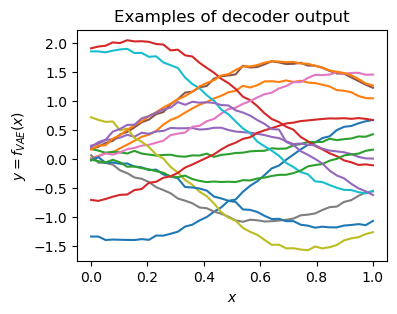

In [9]:
# apply decoder with trained parameters on the data
out = new_decoder.apply({'params': trained_decoder_params}, z_c)             

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(sample_x_train[0], out[i,:])
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of decoder output')

plt.show()